# Исследование результатов A/А/В-теста продуктового магазина

В ходе данного исследования необходимо разобраться, как ведут себя пользователи мобильного приложения стартапа, который продаёт продукты питания. 

Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

В качестве исходных данных предоставлен лог пользователей, в который записаны события, уникальные номера пользователей, время собыьтий и принадлежность пользователя той или иной группе. На основании этих данных и будем выполнять исследование.

## Изучение общей информации и поготовка данных

Импортируем все необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import math as mth

from plotly import graph_objects as go
from matplotlib import pyplot as plt
from scipy import stats as st

import plotly.io as pio
pio.renderers.default = 'png'

Загрузим лог с действиями пользователей. Для удоства работы названия столбцов приведем к более удобочитаемому виду.

In [2]:
try:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')
    
logs.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']
logs

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


**Описание данных:**

Каждая запись в логе — это действие пользователя, или событие.

- `event_name` — название события;
- `device_id_hash` — уникальный идентификатор пользователя;
- `event_timestamp` — время события;
- `exp_id` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Для лучшего восприятия добавим столбец, в котором контрольные группы 246 и 247 обозначим А1 и А2, а экспериментальную группу 248 - B. 

In [3]:
logs['exp_group'] = logs['exp_id'].replace({246:'A1', 247:'A2', 248:'B'})

Добавим в датасет столбец с указанием даты и времени, а также столбец с указанием даты на основании значений `event_timestamp`.

In [4]:
logs['date_time'] = pd.to_datetime(logs.event_timestamp, unit='s')
logs['date'] = pd.to_datetime(logs['date_time'].dt.date)

In [5]:
logs

,event_name,device_id_hash,event_timestamp,exp_id,exp_group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,A1,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,A1,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,B,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,B,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,B,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,A2,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,A1,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,A1,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,A1,2019-08-07 21:14:58,2019-08-07


Выведем информацию о датасете.

In [6]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   exp_id           244126 non-null  int64         
 4   exp_group        244126 non-null  object        
 5   date_time        244126 non-null  datetime64[ns]
 6   date             244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 13.0+ MB


Сохраним начальный размер датасета в переменную `data_old_size`

In [7]:
logs_old_size = len(logs)

Проверим данные на наличие полных дубликатов строк, а также посмотрим на количество пропусков по столбцам.

In [8]:
print('Количество полных дубликатов строк:', logs.duplicated().sum())
print('')
print('Количество пропусков по столбцам:')
print(logs.isna().sum())

Количество полных дубликатов строк: 413

Количество пропусков по столбцам:
event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
exp_group          0
date_time          0
date               0
dtype: int64


Пропуски в датафрейме отсутствуют. Посморим, для каких событий имеются полные дубликаты строк.

In [9]:
logs[logs.duplicated()]['event_name'].unique()

array(['MainScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Подобные дубликаты могут быть вызваны техническими ошибками. Удалим их из датасета.

In [10]:
logs = logs.drop_duplicates()

Проверим, есть ли ошибки в распределении пользователей по группам. Сгруппируем датафрейм по ID пользователя и для каждого посчитаем уникальное количество групп `exp_id`. Выведем на экран всех пользователей с количеством уникальных групп более 1 (при наличии).

In [11]:
logs.groupby('device_id_hash', as_index=False)['exp_id'].nunique().query('exp_id > 1')

,device_id_hash,exp_id


Пользователи, попавшие одновременно в 2 и более групп отсутствуют.

Проверим, какую часть датасета мы потеряли в результате предобработки данных.

In [12]:
print(f'В результате предобработки утрачено {round(((1-len(logs)/logs_old_size)*100), 2)}% данных')

В результате предобработки утрачено 0.17% данных


**Вывод:** в результате обработки данные подготовлены для работы: названия столбцов приведены к удобочитаемому виду, группам пользователей присвоены имена, добавлены столбцы с датой и временем в стандартном формате, удалены полные дубликаты строк.

## Изучение и проверка данных

Изучим и проверим данные. Выясним следующее:

- Сколько всего событий и пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период мы располагаем? Определим, с какого момента данные полные и отбросим более старые.
- Сколько событий и пользователей вы потеряли, отбросив старые данные?
- Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

Посмотрим виды событий, которые содержатся в логе.

In [13]:
logs

,event_name,device_id_hash,event_timestamp,exp_id,exp_group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,A1,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,A1,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,B,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,B,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,B,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,A2,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,A1,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,A1,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,A1,2019-08-07 21:14:58,2019-08-07


In [14]:
print(logs.event_name.unique())

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


**Виды событий:**

- `MainScreenAppear` - показ главной страницы
- `OffersScreenAppear` - показ экрана с предложениями магазина
- `CartScreenAppear` - показ страницы корзины
- `PaymentScreenSuccessful` - показ экрана успешной оплаты
- `Tutorial` - показ экрана с обучением

Посмотрим количество уникальных пользователей, события по которым представлены в логе, а также количество самих событий.

In [15]:
print(f'В логе представлены события по {logs.device_id_hash.nunique()} пользователю.')
print(f'Всего содержится {len(logs)} событий.')

В логе представлены события по 7551 пользователю.
Всего содержится 243713 событий.


Построим диаграмму рассеяния для количества событий по пользователям. Для этого создадим временную таблицу `t` в которой для каждого пользователя посчиатем количество событий.

In [16]:
t = logs.groupby('device_id_hash')['event_timestamp'].count().reset_index()
t.head()

,device_id_hash,event_timestamp
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137


По данным значениям построим диаграмму рассеяния. Покажем также линию 99-го перцентиля. Выше нее будет располагаться 1% пользователей с самым большим количеством заказов.

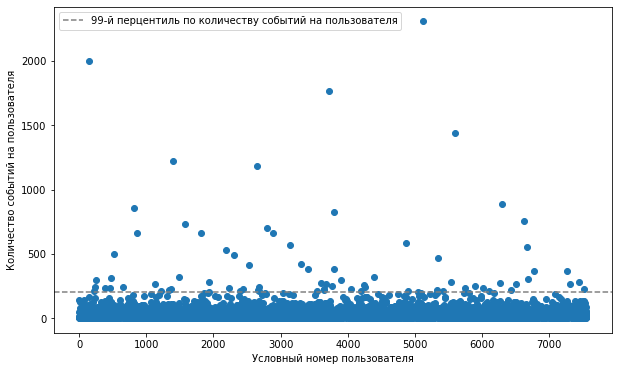

In [17]:
plt.figure(figsize=(10,6))
plt.scatter(x=t.index, y=t['event_timestamp'])
plt.xlabel('Условный номер пользователя')
plt.ylabel('Количество событий на пользователя')
plt.axhline(y=np.percentile(t['event_timestamp'], 99), color='grey',\
            linestyle='--', label='99-й перцентиль по количеству событий на пользователя')
plt.legend()
plt.show()

In [18]:
print(f'Для 99% пользователей количество событий за исследуемый период не превышает\
 {round(np.percentile(t["event_timestamp"], 99))} на одного пользователя.')

Для 99% пользователей количество событий за исследуемый период не превышает 200 на одного пользователя.


Отметим, что в логе есть очень активные пользователи, для которых за исследуемый период зафиксировано более 200 (до 2300) событий.

Найдем среднее количество событий на одного пользователя.

In [19]:
print(f'В среднем по датасету приходится {round(len(logs)/logs.device_id_hash.nunique())} события на одного пользователя.')

В среднем по датасету приходится 32 события на одного пользователя.


In [20]:
print(f'В логе представлены данные с {logs.date.min().date()} по {logs.date.max().date()}.')

В логе представлены данные с 2019-07-25 по 2019-08-07.


Построим гистограмму распределения количества событий по датам.

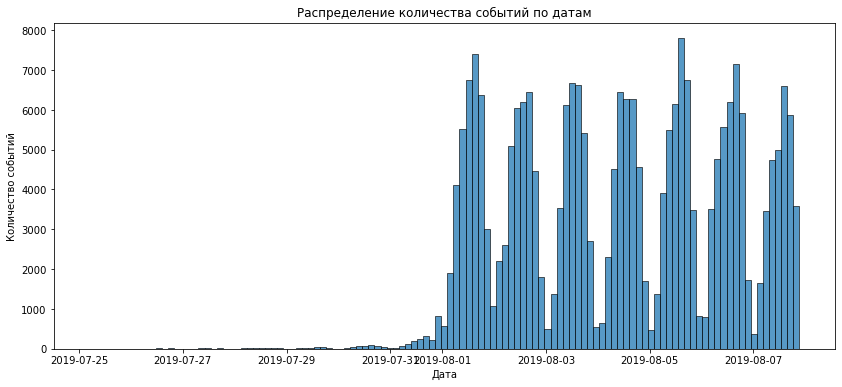

In [21]:
plt.figure(figsize=(14,6))
sns.histplot(logs.date_time)
plt.title('Распределение количества событий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

По приведенному выше графику можно заметить, что до 1 августа 2019г. фиксировалось очень низкое количество событий. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». С 1 августа мы имеем полные данные, поэтому далее будем рассматривать период с 2019-08-01 по 2019-08-07.

Сохраним текущий лог в переменную `old_logs`.

In [22]:
old_logs = logs.copy()

Исключим из рабочего датафрейма события, записанные ранее 1 августа 2019 г.

In [23]:
logs = logs.query('date >= "2019-08-01"').reset_index(drop=True)

In [24]:
logs

,event_name,device_id_hash,event_timestamp,exp_id,exp_group,date_time,date
0,Tutorial,3737462046622621720,1564618048,246,A1,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,A1,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,A1,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,A1,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,1564618139,247,A2,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...,...
240882,MainScreenAppear,4599628364049201812,1565212345,247,A2,2019-08-07 21:12:25,2019-08-07
240883,MainScreenAppear,5849806612437486590,1565212439,246,A1,2019-08-07 21:13:59,2019-08-07
240884,MainScreenAppear,5746969938801999050,1565212483,246,A1,2019-08-07 21:14:43,2019-08-07
240885,MainScreenAppear,5746969938801999050,1565212498,246,A1,2019-08-07 21:14:58,2019-08-07


Проверим, сколько пользователей мы потеряли в результате того, что отбросили часть данных. Аналогично проверим количество утраченных событий.

In [25]:
print(f'Количество утраченных пользователей: {old_logs.device_id_hash.nunique()-logs.device_id_hash.nunique()}')
print(f'Доля утраченных пользователей: {round((1-logs.device_id_hash.nunique()/old_logs.device_id_hash.nunique())*100, 2)}%')
print('')
print(f'Количество утраченных событий: {len(old_logs)-len(logs)}')
print(f'Доля утраченных событий: {round((1-len(logs)/len(old_logs))*100, 2)}%')

Количество утраченных пользователей: 17
Доля утраченных пользователей: 0.23%

Количество утраченных событий: 2826
Доля утраченных событий: 1.16%


Посмотрим количество пользователей по группам после выполненной обработки данных.

In [26]:
users_by_group = logs.groupby('exp_group', as_index=False)['device_id_hash'].nunique().rename(columns={'device_id_hash':'cnt'})
users_by_group['share'] = round(users_by_group.cnt/users_by_group.cnt.sum(), 3)
users_by_group

,exp_group,cnt,share
0,A1,2484,0.330
1,A2,2513,0.334
2,B,2537,0.337


В отфильтрованном датафрейме имеются пользователи из всех трех групп. Наибольшая разница между группами (А1 и В) составляет 0.7%, что является допустимым.

**Вывод:**

В логе содержатся следующие виды событий:
- `MainScreenAppear` - показ главной страницы
- `OffersScreenAppear` - показ экрана с предложениями магазина
- `CartScreenAppear` - показ страницы корзины
- `PaymentScreenSuccessful` - показ экрана успешной оплаты
- `Tutorial` - показ экрана с обучением.

Для 99% пользователей количество событий за исследуемый период не превышает 200 на одного пользователя. В логе есть очень активные пользователи, для которых за исследуемый период зафиксировано более 200 (до 2300) событий. В среднем по датасету приходится 32 события на одного пользователя.

В исходном логе данные предоставлены за период с 2019-07-25 по 2019-08-07.

С помощью построенной гистограммы распределения установлено, что до 1 августа 2019г. фиксировалось очень низкое количество событий. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Для дальнейшей работы данные отфильтрованы и взяты логи событий за период с 2019-08-01 по 2019-08-07.
 
В результате фильтрации утрачены данные по 17 пользователям (0.23% от общего количества) и по 2826 событиям (1.16%). В отфильтрованном датафрейме имеются пользователи из всех трех групп (около 2500 пользователей в каждой). Наибольшая разница между группами (А1 и В) составляет 0.7%, что является допустимым.

## Изучение воронки событий

Посмотрим, какие события есть в логах и как часто они встречаются. Посчитаем, сколько пользователей совершали каждое из этих событий. Вычислим долю пользователей, которые хоть раз совершали событие.

Изучим события и выстроим последовательную цепочку событий.

Построим воронку событий и посчитаем, какая доля пользователей проходит на каждый следующий шаг воронки (от числа пользователей на предыдущем). Выясним, на каком шаге теряете больше всего пользователей и какая доля пользователей доходит от первого события до оплаты.


Посмотрим, какие события есть в логах и как часто они встречаются. Отобразим результат в виде горизонтальной столбчатой диаграммы.

,count
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


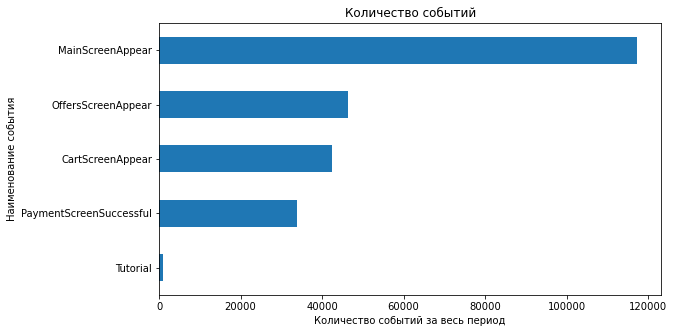

In [27]:
# Создадим таблицу, в которой для каждого собыьтя посчитаем количество записей в логе
display(logs.groupby('event_name')['event_timestamp'].count().sort_values(ascending=False)\
.to_frame().rename(columns={'event_timestamp':'count'}))

# Построим горизонтальную столбчатую диаграмму
plt.figure(figsize=(9,5))
logs.groupby('event_name')['event_timestamp'].count().sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Количество событий за весь период')
plt.ylabel('Наименование события')
plt.title('Количество событий')
plt.show()

Вычислим сколько пользователей совершали каждое из этих событий. Также посчитаем долю пользователей от их общего количества, которые хоть раз совершали каждое из событий.

,user_count,share
event_name,,
MainScreenAppear,7419,0.98
OffersScreenAppear,4593,0.61
CartScreenAppear,3734,0.50
PaymentScreenSuccessful,3539,0.47
Tutorial,840,0.11


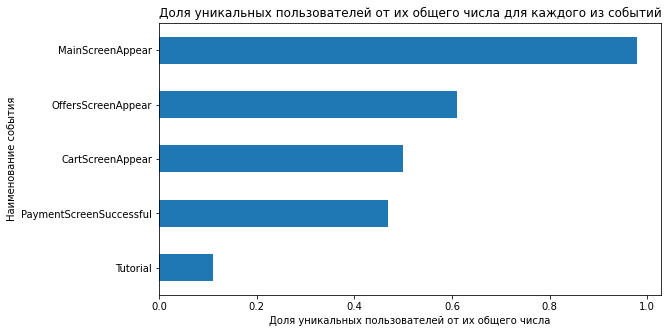

In [28]:
# Создадим таблицу, где для каждого события вычислим количество уникальных пользователей
event_user_cnt = logs.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False)\
.to_frame().rename(columns={'device_id_hash':'user_count'})
# Добавм столбец, где будет указана доля пользователей совершивших событие от их общего числа
event_user_cnt['share'] = round(event_user_cnt.user_count / logs.device_id_hash.nunique(), 2)
display(event_user_cnt)

plt.figure(figsize=(9,5))
event_user_cnt.share.sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Доля уникальных пользователей от их общего числа')
plt.ylabel('Наименование события')
plt.title('Доля уникальных пользователей от их общего числа для каждого из событий')
plt.show()

Выстроим последовательную цепочку событий для пользователя. В скобках укажем долю уникальных пользователей от их общего числа для каждого из событий.

Логично предположить, что событие с обучением выполняется пользователи в самом начале работы с сервисом. Поскольку событие оно имеет низкую долю пользователей (0.11), это означает, что его можно пропустить в самом начале, пройти позже, либо совсем не проходить. Его не будем учитывать в иследуемой последовательности событий.

Последовательность событий выглядит следующим образом:
1. Показ главной страницы `MainScreenAppear` (98% пользователей)
2. Показ экрана с предложениями магазина `OffersScreenAppear` (61% пользователей)
3. Показ страницы корзины `CartScreenAppear` (50% пользователей)
4. Показ экрана успешной оплаты `PaymentScreenSuccessful` (47% пользователей)

Построим воронку событий и посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Для из ранее созданной таблица `event_user_cnt` удалим строку Tutorial, поскольку она не учитывается в воронке событий. Также добавим столбец `share_funnel`, в котором будет указана доля пользователей от их количества на предыдущем событии.

In [29]:
event_user_cnt = event_user_cnt[event_user_cnt.index != 'Tutorial']
event_user_cnt['share_funnel'] = round(event_user_cnt['user_count'] / event_user_cnt['user_count'].shift(1), 2)
event_user_cnt = event_user_cnt.fillna(1)
event_user_cnt

,user_count,share,share_funnel
event_name,,,
MainScreenAppear,7419,0.98,1.00
OffersScreenAppear,4593,0.61,0.62
CartScreenAppear,3734,0.50,0.81
PaymentScreenSuccessful,3539,0.47,0.95


Построим воронку событий.

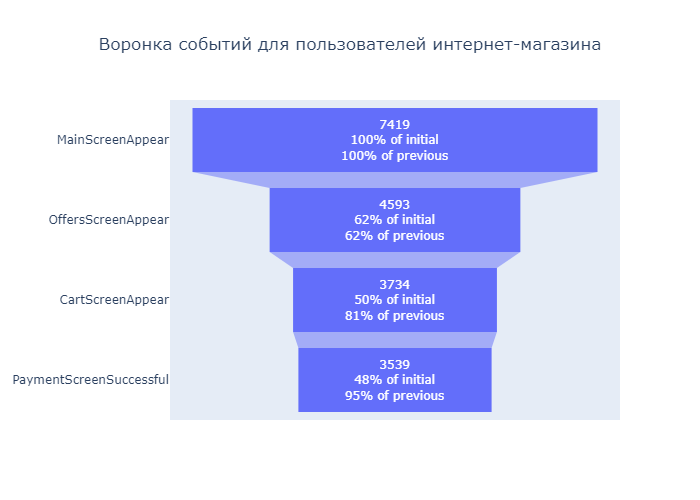

In [30]:
funn = go.Figure(go.Funnel(
    y=event_user_cnt.index, x=event_user_cnt.user_count, textinfo = 'value+percent previous+percent initial'
))

funn.update_layout(title=dict(text="Воронка событий для пользователей интернет-магазина", x=0.5))
funn.show()

Данная воронка демонстрирует:
- количество пользователей, для которых произошло событие
- процент от числа пользователей первого события (% of initial)
- процент от числа пользователей предыдущего события (% of previous)

Наибольшее количество пользователей (38%) теряется на шаге перехода с главного экрана на экран с предложениями продуктов магазина. 81% пользователей, просмотревших товары магазина, заходят в раздел "Корзина". И 95% пользователей, просмотревших корзину, совершают оплату.

От события *показ главной страницы `MainScreenAppear`* до события *показ экрана успешной оплаты `PaymentScreenSuccessful`* доходит 48% пользователей.

**Вывод:**

В ходе исследования установлена последовательность событий для пользователя, которая выглядит следующим образом:
1. Показ главной страницы `MainScreenAppear` (98% пользователей)
2. Показ экрана с предложениями магазина `OffersScreenAppear` (61% пользователей)
3. Показ страницы корзины `CartScreenAppear` (50% пользователей)
4. Показ экрана успешной оплаты `PaymentScreenSuccessful` (47% пользователей)

Обучение `Tutorial` в целях изучения воронки событий не рассматривается, т.к. может быть пропущено на начальном этапе.

Построенная воронка событий демонстрирует следующее: наибольшее количество пользователей (38%) теряется на шаге перехода с главного экрана на экран с предложениями продуктов магазина. 81% пользователей, просмотревших товары магазина, заходят в раздел "Корзина". И 95% пользователей, просмотревших корзину, совершают оплату. От события *показ главной страницы `MainScreenAppear`* до события *показ экрана успешной оплаты `PaymentScreenSuccessful`* доходит 48% пользователей.

## Изучение результатов эксперимента

Проверить корректность всех механизмов и расчётов путем сравнения контрольных групп А1 и А2. Проверьте, находят ли статистические критерии между ними разницу.

Выберем самое популярное событие и посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически значимым.  Проделаем то же самое для всех других событий. Проверим, корректно ли выполнено разбиение пользователей на группы.

Аналогичные действия выполним с группой с изменённым шрифтом (группа В). Сравним результаты с каждой из контрольных групп в отдельности по каждому событию а также с объединённой контрольной группой.

Посмотрим на распределение пользователей по группам.

In [31]:
users_by_group

,exp_group,cnt,share
0,A1,2484,0.330
1,A2,2513,0.334
2,B,2537,0.337


Наибольшая разница между группами (А1 и В) составляет 0.7%, что является допустимым. Распределение пользователей по группам выполнено качественно.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

Чтобы проверить корректность всех механизмов и расчётов, проверим, находят ли статистические критерии разницу между выборками А1 и А2.

Для этого создадим сводную таблицу `groups`, в которой сгруппируем данные по группам и по каждой группе укажем количество уникальных пользователей для различных событий (за исключением обучения, которое не включено в последовательность событий).

In [32]:
groups = logs.pivot_table(index='exp_group', columns='event_name', values='device_id_hash', aggfunc='nunique')
groups = groups[['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']]
groups = groups.merge(users_by_group[['cnt', 'exp_group']], on='exp_group')
groups = groups.rename(columns={'cnt':'count_users'}).set_index('exp_group')
groups

,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,count_users
exp_group,,,,,
A1,2450,1542,1266,1200,2484
A2,2476,1520,1238,1158,2513
B,2493,1531,1230,1181,2537


В ходе проверки гипотез будем искать различия в долях пользователей от их общего количества для определенного события.

Установим нулевую и альтернативную гипотезы:

 - H0 - разницы между группами нет, доли равны.
 - H1 - есть разница между группами, доли не равны.
 
Для статистических тестов зададим параметр статистической значимости *alpha* равным *0.05*.

Для проверки разницы между различными группами создадим функцию `diff_share`, которая на вход будет принимать названия сравниваемых групп,  название события и критический уровень статистической значимости (по умолчанию 0.05). Функция возвращает p-value и результат проверки гипотезы (отвергаем или не отвергаем нулевую гипотезу).

In [33]:
def diff_share(group_one, group_two, item, alpha=.05):

    successes_users = np.array([groups.loc[group_one, item], groups.loc[group_two, item]])
    trials_users = np.array([groups.loc[group_one, 'count_users'], groups.loc[group_two, 'count_users']])

    # пропорция успехов в первой группе:
    p1 = successes_users[0]/trials_users[0]

    # пропорция успехов во второй группе:
    p2 = successes_users[1]/trials_users[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes_users[0] + successes_users[1]) / (trials_users[0] + trials_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_users[0] + 1/trials_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('-'*30)
    print(f'Сравниваем доли пользователей групп {group_one} и {group_two} для события {item}.')
    print(f'p-значение: {round(p_value, 4)}.')
    print(f'alpha (критический уровень статистической значимости): {alpha}.')

    if p_value < alpha:
        return print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
    else:
        return print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')
    

In [34]:
for i in groups.columns[:-1]:
    diff_share('A1', 'A2', i)

------------------------------
Сравниваем доли пользователей групп A1 и A2 для события MainScreenAppear.
p-значение: 0.7571.
alpha (критический уровень статистической значимости): 0.05.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
------------------------------
Сравниваем доли пользователей групп A1 и A2 для события OffersScreenAppear.
p-значение: 0.2481.
alpha (критический уровень статистической значимости): 0.05.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
------------------------------
Сравниваем доли пользователей групп A1 и A2 для события CartScreenAppear.
p-значение: 0.2288.
alpha (критический уровень статистической значимости): 0.05.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
------------------------------
Сравниваем доли пользователей групп A1 и A2 для события PaymentScreenSuccessful.
p-значение: 0.1146.
alpha (критический уровень статистической значимости): 0.05.
Не получил

**Можно сделать вывод, что разбиение пользователей на группы работает корректно**. При сравнении контрольных групп между собой  статистически значимой разницы не выявлено.

Проделаем ту же процедуру для сравнения экспериментальной группы с контрольными, а также с объединенной контрольной группой. Предварительно добавим строку А1+А2 в датафрейм `groups`.

In [35]:
groups.loc['A2+A1'] = groups.loc['A1'] + groups.loc['A2']
groups.sort_index()

,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,count_users
exp_group,,,,,
A1,2450,1542,1266,1200,2484
A2,2476,1520,1238,1158,2513
A2+A1,4926,3062,2504,2358,4997
B,2493,1531,1230,1181,2537


Далее сравним каждую из контрольных групп `A1`, `A2`, `A2+A1` с экспериментальной группой `B`.

In [36]:
for one_group in ['A1', 'A2', 'A2+A1']:
    print('-'*30)
    for item in groups.columns[:-1]:
        diff_share(one_group, 'B', item)

------------------------------
------------------------------
Сравниваем доли пользователей групп A1 и B для события MainScreenAppear.
p-значение: 0.295.
alpha (критический уровень статистической значимости): 0.05.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
------------------------------
Сравниваем доли пользователей групп A1 и B для события OffersScreenAppear.
p-значение: 0.2084.
alpha (критический уровень статистической значимости): 0.05.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
------------------------------
Сравниваем доли пользователей групп A1 и B для события CartScreenAppear.
p-значение: 0.0784.
alpha (критический уровень статистической значимости): 0.05.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
------------------------------
Сравниваем доли пользователей групп A1 и B для события PaymentScreenSuccessful.
p-значение: 0.2123.
alpha (критический уровень статистической зна

При сравнении экспериментальной группы с контрольными, а также со сборной контрольной группой по всем видам событий статистически значимой разницы не выявлено.

По результатам А/А/В теста можно сделать вывод: **при заданном критическом уровне статистической значимости в 5% не обнаружено статистически значимых отличий в контрольной и экспериментальной группах. Доли пользователей для каждого рассматриваемого события между экспериментальной и контрольными группами равны**.

В ходе эксперимента был проведен множественный тест. Его важная особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода (ложнопозитивный результат). В итоге выполнено 16 проверок статистических гипотез с принятым критическим уровнем статистической значимости в 5%.

Для того, чтобы при множественном тесте снизить вероятность ошибки первого рода, вводят поправку Бонферони, которая учитывает количество проведенных проверок и исходя из этого корректируют критический уровень статистической значимости.

In [37]:
print(f'С учетом поправки Бонферони критический уровень статистической значимости равен {round(.05/16,4)}')

С учетом поправки Бонферони критический уровень статистической значимости равен 0.0031


С учетом введенной поправки alpha становится еще более требовательным для того, чтобы отвергнуть нулевую гипотезу (H0 - разницы между группами нет, доли равны). *Поскольку в нашем А/А/В тесте даже при alpha=0.05 нулевая гипотеза не отвергается, повторно проводить проверку статистических гипотез с откорректированным критическим уровнем статзначимости нецелесообразно. Выводы не изменятся.*

## Общий вывод

В ходе данного исследования исследован лог с запиями событий и выяснено как ведут себя пользователи мобильного приложения стартапа, который продаёт продукты питания. 

Изучена воронка продаж, построена цепочка событий и установлено, сколько пользователей доходит до покупки, а сколько — «застревает» на каждом из предыдущих шагов.

Исследованы результаты A/A/B-эксперимента, в котором пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами в приложении и одну экспериментальную — с новыми.

В качестве исходных данных предоставлен лог пользователей, в котороза записаны события, уникальные номера пользователей, время собыьтий и принадлежность пользователя той или иной группе. На основании этих данных и будем выполнять исследование.

**Подготовка данных**

В результате обработки данные подготовлены для работы: названия столбцов приведены к удобочитаемому виду, группам пользователей присвоены имена, добавлены столбцы с датой и временем в стандартном формате, удалены полные дубликаты строк.

**Изучение и проверка данных**

В логе содержатся следующие виды событий:
- `MainScreenAppear` - показ главной страницы
- `OffersScreenAppear` - показ экрана с предложениями магазина
- `CartScreenAppear` - показ страницы корзины
- `PaymentScreenSuccessful` - показ экрана успешной оплаты
- `Tutorial` - показ экрана с обучением.

Для 99% пользователей количество событий за исследуемый период не превышает 200 на одного пользователя. В логе есть очень активные пользователи, для которых за исследуемый период зафиксировано более 200 (до 2300) событий. В среднем по датасету приходится 32 события на одного пользователя.

В исходном логе данные предоставлены за период с 2019-07-25 по 2019-08-07. Для анализа данные отфильтрованы и взяты логи событий за период с 2019-08-01 по 2019-08-07.
 
В результате фильтрации утрачены данные по 17 пользователям (0.23% от общего количества) и по 2826 событиям (1.16%). В отфильтрованном датафрейме имеются пользователи из всех трех групп (около 2500 пользователей в каждой). Наибольшая разница между группами (А1 и В) составляет 0.7%, что является допустимым.

**Изучение воронки событий**

В ходе исследования установлена последовательность событий для пользователя, которая выглядит следующим образом:
1. Показ главной страницы `MainScreenAppear` (98% пользователей)
2. Показ экрана с предложениями магазина `OffersScreenAppear` (61% пользователей)
3. Показ страницы корзины `CartScreenAppear` (50% пользователей)
4. Показ экрана успешной оплаты `PaymentScreenSuccessful` (47% пользователей)

Обучение `Tutorial` в целях изучения воронки событий не рассматривается, т.к. может быть пропущено на начальном этапе.

Воронка событий демонстрирует следующее: наибольшее количество пользователей (38%) теряется на шаге перехода с главного экрана на экран с предложениями продуктов магазина. 81% пользователей, просмотревших товары магазина, заходят в раздел "Корзина". И 95% пользователей, просмотревших корзину, совершают оплату. От события *показ главной страницы `MainScreenAppear`* до события *показ экрана успешной оплаты `PaymentScreenSuccessful`* доходит 48% пользователей.

**Изучение результатов эксперимента**

Разбиение пользователей на группы выполнено корректно. При сравнении контрольных групп между собой статистически значимой разницы не выявлено.

При сравнении экспериментальной группы с контрольными, а также со сборной контрольной группой по всем видам событий статистически значимой разницы не выявлено.

По результатам А/А/В теста можно сделать вывод: **при заданном критическом уровне статистической значимости в 5% не обнаружено статистически значимых отличий в контрольной и экспериментальной группах. Доли пользователей для каждого рассматриваемого события между экспериментальной и контрольными группами равны**.

**На основании проведенного теста можно утверждать, что изменение дизайнерами шрифтов в приложении не повлияет на поведение пользователей.**